# Stop Reinventing Pandas

The following post was first presented as a talk for the [IE@DS](https://www.facebook.com/groups/173376299978861/) community. It will also be presented at [PyData meetup](https://www.meetup.com/PyData-Tel-Aviv/) in December.  
All the resources for this post, including a runable notebook, can be found in the [github repo](https://github.com/DeanLa/dont_reinvent_pandas)

![slide1](slides/slide1.jpg)

![slide2](slides/slide2.jpg)

This notebook aims to show some nice ways modern Pandas makes your life easier. It is not about efficiency. I'm pretty sure using Pandas' built-in methods will be more efficient than reinventing pandas, but the main goal is to make the code easier to read, and more imoprtant - easier to write.

![slide3](slides/slide3.jpg)

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['classic', 'ggplot', 'seaborn-poster', 'dean.style'])
%load_ext autoreload
%autoreload 2
import my_utils

# First Hacks!


Reading the data and a few housekeeping tasks. is the first place we can make our code more readable.

In [2]:
df_io = pd.read_csv('./data.csv',index_col=0,parse_dates=['date_'])
df_io.head()

,val_updated,date_,event_type
0,2018-10-09 17:01:30.662390+00:00,2018-10-09 17:01:30.662389,5
1,2018-10-09 17:01:30.687675+00:00,2018-10-09 17:01:30.687675,5
2,2018-10-09 17:03:23.952848+00:00,2018-10-09 17:03:23.952847,1
3,2018-10-09 17:05:42.327744+00:00,2018-10-09 17:05:42.327744,7
4,2018-09-24 16:36:38.177661+00:00,2018-10-09 17:06:29.708909,7


In [3]:
df = df_io.copy().sort_values('date_').set_index('date_').drop(columns='val_updated')
df.head()

,event_type
date_,
2018-10-09 17:01:30.662389,5
2018-10-09 17:01:30.687675,5
2018-10-09 17:03:23.952847,1
2018-10-09 17:05:42.327744,7
2018-10-09 17:06:29.708909,7


## Beautiful pipes!
One line method chaining is hard to read and prone to human error, chaining each method in its own line makes it a lot more readable.

In [4]:
df_io\
.copy()\
.sort_values('date_')\
.set_index('date_')\
.drop(columns='val_updated')\
.head()

,event_type
date_,
2018-10-09 17:01:30.662389,5
2018-10-09 17:01:30.687675,5
2018-10-09 17:03:23.952847,1
2018-10-09 17:05:42.327744,7
2018-10-09 17:06:29.708909,7


But it has a problem. You can't comment out and even comment in between

In [5]:
# This block will result in an error
df_io\
.copy()\ # This is an inline comment
# This is a regular comment
.sort_values('date_')\
# .set_index('date_')\
.drop(columns='val_updated')\ 
.head()

SyntaxError: unexpected character after line continuation character (<ipython-input-5-f6a35867b44d>, line 2)

Even an unnoticeable space character may break everything

In [6]:
# This block will result in an error
df_io\
.copy()\
.sort_values('date_')\
.set_index('date_')\
.drop(columns='val_updated')\ 
.head()

SyntaxError: unexpected character after line continuation character (<ipython-input-6-708b932ea07a>, line 2)

## The Penny Drops
I like those "penny dropping" moments, when you realize you knew everything that is presented, yet it is presented in a new way you never thought of.

In [7]:
# We can split these value inside ()
users = (134856, 195373, 295817, 294003, 262166, 121066, 129678, 307120,
         258759, 277922, 220794, 192312, 318486, 314631, 306448, 297059,206892, 
         169046, 181703, 146200, 199876, 247904, 250884, 282989, 234280, 202520,
         138064, 133577, 301053, 242157)

In [8]:
# Penny Drop: We can also Split here
df = (df_io
        .copy() # This is an inline comment
        # This is a regular comment
        .sort_values('date_')
        .set_index('date_')
        .drop(columns='val_updated')   
)

df.head()

,event_type
date_,
2018-10-09 17:01:30.662389,5
2018-10-09 17:01:30.687675,5
2018-10-09 17:03:23.952847,1
2018-10-09 17:05:42.327744,7
2018-10-09 17:06:29.708909,7


## Map with dict
A dict is a callable with $f(key) = value$, there for you can call `.map` with it. In this example I want to make int key codes into letter.

In [9]:

df.event_type.map(lambda x: x+3).head()

date_
2018-10-09 17:01:30.662389     8
2018-10-09 17:01:30.687675     8
2018-10-09 17:03:23.952847     4
2018-10-09 17:05:42.327744    10
2018-10-09 17:06:29.708909    10
Name: event_type, dtype: int64

In [10]:
# A dict is also a calleble
df['event_type'] = df.event_type.map({
    1:'A',
    5:'B',
    7:'C'
})
df.head()

,event_type
date_,
2018-10-09 17:01:30.662389,B
2018-10-09 17:01:30.687675,B
2018-10-09 17:03:23.952847,A
2018-10-09 17:05:42.327744,C
2018-10-09 17:06:29.708909,C


# Time Series


## Resample
Task: How many events happen each hour?

### The Old Way

In [11]:
bad = df.copy()
bad['day'] = bad.index.date
bad['hour'] = bad.index.hour
(bad
.groupby(['day','hour'])
.count()
)

event_type
day        hour            
2018-10-09 17            83
           18            96
           20            91
           21            71
           22            84

* Many lines of code
* unneeded columns
* Index is not a time anymore
* **missing rows** (Did you notice?)

### A Better Way

In [12]:
df.resample('H').count() # H is for Hour

,event_type
date_,
2018-10-09 17:00:00,83
2018-10-09 18:00:00,96
2018-10-09 19:00:00,0
2018-10-09 20:00:00,91
2018-10-09 21:00:00,71
2018-10-09 22:00:00,84


But it's even better on non-round intervals

In [13]:
rs = df.resample('10T').count()
# T is for Minute, and pandas understands 10 T, it will also under stand 11T if you wonder
rs.head()

,event_type
date_,
2018-10-09 17:00:00,7
2018-10-09 17:10:00,12
2018-10-09 17:20:00,16
2018-10-09 17:30:00,13
2018-10-09 17:40:00,15


[Complete list of Pandas' time abbrevations](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Period.strftime.html)

## Slice Easily
Pandas will automatically make string into timestamps, and it will understand what you want it to do.

In [14]:
# Take only timestamp in the hour of 21:00.
rs.loc['2018-10-09 21',:]

,event_type
date_,
2018-10-09 21:00:00,11
2018-10-09 21:10:00,18
2018-10-09 21:20:00,16
2018-10-09 21:30:00,9
2018-10-09 21:40:00,7
2018-10-09 21:50:00,10


In [15]:
# Take all time stamps berfore 18:31
rs.loc[:'2018-10-09 18:31',:]

,event_type
date_,
2018-10-09 17:00:00,7
2018-10-09 17:10:00,12
2018-10-09 17:20:00,16
2018-10-09 17:30:00,13
2018-10-09 17:40:00,15
2018-10-09 17:50:00,20
2018-10-09 18:00:00,21
2018-10-09 18:10:00,22
2018-10-09 18:20:00,4


## Time Windows: Rolling, Expanding, EWM
If your Dataframe is indexed on a time index (Which 

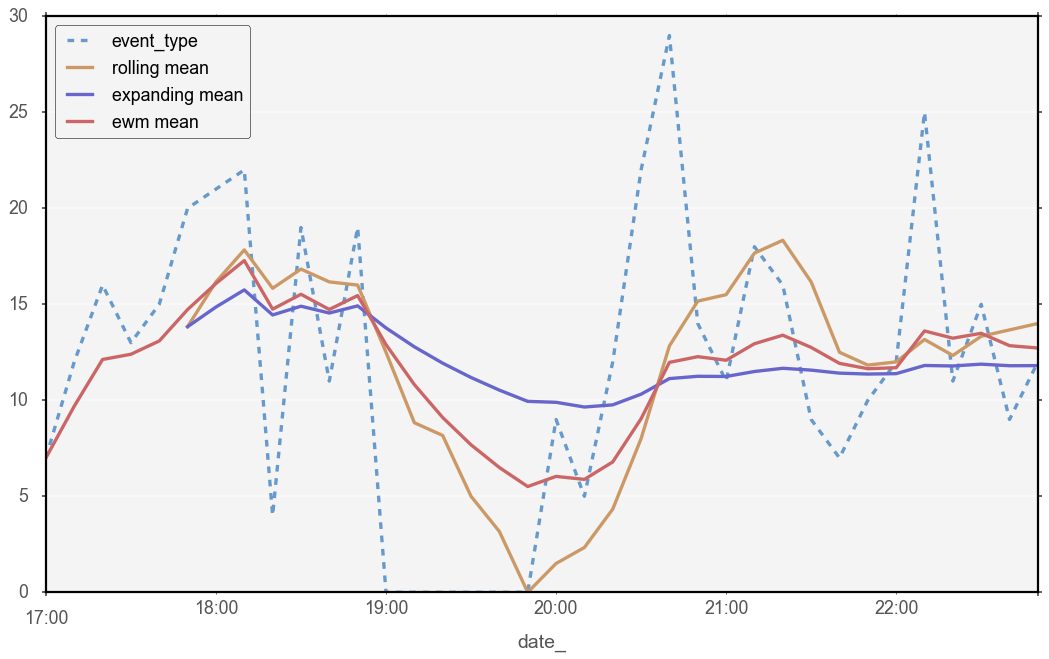

In [25]:
fig, ax = plt.subplots()
rs.plot(ax=ax,linestyle='--')
(rs
 .rolling(6)
 .mean()
 .rename(columns = {'event_type':'rolling mean'})
 .plot(ax=ax)
)

rs.expanding(6).mean().rename(columns = {'event_type':'expanding mean'}).plot(ax=ax)
rs.ewm(6).mean().rename(columns = {'event_type':'ewm mean'}).plot(ax=ax)
plt.show()

### With Apply
Intuitively, windows are like GroupBy, so you can apply anything you want after the grouping, e.g.: geometric mean.

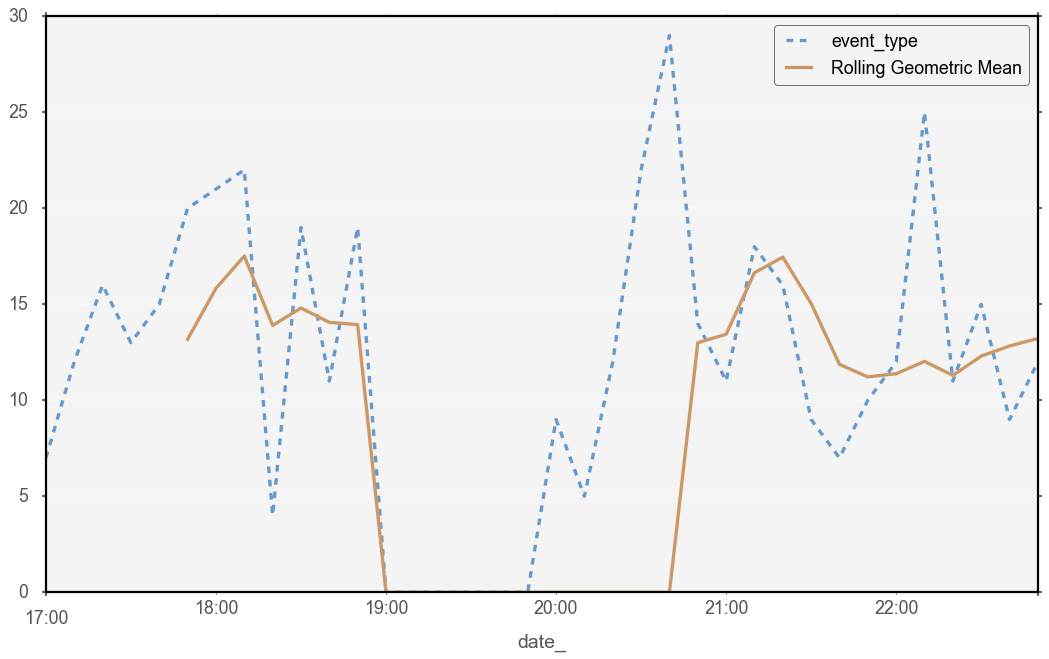

In [22]:
fig, ax = plt.subplots()
rs.plot(ax=ax,linestyle='--')
(rs
 .rolling(6)
 .apply(lambda x: np.power(np.product(x),1/len(x)) )
 .rename(columns = {'event_type':'Rolling Geometric Mean'})
 .plot(ax=ax)
)
plt.show()

## Combine with GroupBy 🤯
Pandas has no problem with groupby and resample together. It's as simple as `groupby[col1,col2]`. In our specific case, we want to cound events in an interval per event type.

In [27]:
per_event = (df
             .groupby('event_type')
             .resample('15T')
             .apply('count')
             .rename(columns={'event_type':'amount'})
            )
per_event

amount
event_type date_                      
A          2018-10-09 17:00:00       8
           2018-10-09 17:15:00       6
           2018-10-09 17:30:00       6
           2018-10-09 17:45:00       9
           2018-10-09 18:00:00       3
           2018-10-09 18:15:00       2
           2018-10-09 18:30:00       1
           2018-10-09 18:45:00      12
           2018-10-09 19:00:00       0
           2018-10-09 19:15:00       0
           2018-10-09 19:30:00       0
           2018-10-09 19:45:00       0
           2018-10-09 20:00:00       2
           2018-10-09 20:15:00       1
           2018-10-09 20:30:00       8
           2018-10-09 20:45:00      12
           2018-10-09 21:00:00       7
           2018-10-09 21:15:00       5
           2018-10-09 21:30:00       2
           2018-10-09 21:45:00       1
           2018-10-09 22:00:00      10
           2018-10-09 22:15:00      11
           2018-10-09 22:30:00       2
           2018-10-09 22:45:00       1
B          2018-10-09 17:00:00       4
           2018-10-09 17:15:00      11
           2018-10-09 17:30:00       9
           2018-10-09 17:45:00      10
           2018-10-09 18:00:00      18
           2018-10-09 18:15:00      11
...                                ...
           2018-10-09 21:30:00       7
           2018-10-09 21:45:00      10
           2018-10-09 22:00:00      12
           2018-10-09 22:15:00       7
           2018-10-09 22:30:00      12
           2018-10-09 22:45:00      14
C          2018-10-09 17:00:00       2
           2018-10-09 17:15:00       4
           2018-10-09 17:30:00       4
           2018-10-09 17:45:00      10
           2018-10-09 18:00:00       7
           2018-10-09 18:15:00       6
           2018-10-09 18:30:00       8
           2018-10-09 18:45:00       3
           2018-10-09 19:00:00       0
           2018-10-09 19:15:00       0
           2018-10-09 19:30:00       0
           2018-10-09 19:45:00       0
           2018-10-09 20:00:00       4
           2018-10-09 20:15:00       5
           2018-10-09 20:30:00      12
           2018-10-09 20:45:00       7
           2018-10-09 21:00:00       9
           2018-10-09 21:15:00       8
           2018-10-09 21:30:00       3
           2018-10-09 21:45:00       3
           2018-10-09 22:00:00       4
           2018-10-09 22:15:00       4
           2018-10-09 22:30:00       4
           2018-10-09 22:45:00       3

[72 rows x 1 columns]

# Stack, Unstack

## Unstack 
In this case, working with a wide format indexed on intervals, with event types as columns, will make a lot more sense.

### The Old way
Pivot table in modern pandas is more robust than it used to be. Still, it requires you to specify everything.

In [68]:
pt = pd.pivot_table(per_event,values = 'amount',columns='event_type',index='date_')
pt.head()

event_type,A,B,C
date_,,,
2018-10-09 17:00:00,8,4,2
2018-10-09 17:15:00,6,11,4
2018-10-09 17:30:00,6,9,4
2018-10-09 17:45:00,9,10,10
2018-10-09 18:00:00,3,18,7


### A better way
When you have just one column of values, unstack does the same easily

In [69]:
pt = per_event.unstack('event_type')
pt.columns = pt.columns.droplevel() # Unstack creates a multiindex on columns
pt.head()

event_type,A,B,C
date_,,,
2018-10-09 17:00:00,8,4,2
2018-10-09 17:15:00,6,11,4
2018-10-09 17:30:00,6,9,4
2018-10-09 17:45:00,9,10,10
2018-10-09 18:00:00,3,18,7


## Unstack
And some extra tricks

In [70]:
pt.stack().head()

date_                event_type
2018-10-09 17:00:00  A              8
                     B              4
                     C              2
2018-10-09 17:15:00  A              6
                     B             11
dtype: int64

This looks kind of what we had expected but:
* It's a series, not a DataFrame
* The levels of the index are reversed
* The main sort is on the date, yet it used to be on the event type

In [64]:
stack_back = (pt
              .stack()
              .to_frame('amount') # Turn Series to DF without calling the DF constructor
              .swaplevel() # Swaps the levels of the index
              .sort_index() # Sort by index, makes so much sense yet I used to do .reset_index().sort_values()
             )
stack_back.head()

amount
event_type date_                      
A          2018-10-09 17:00:00       8
           2018-10-09 17:15:00       6
           2018-10-09 17:30:00       6
           2018-10-09 17:45:00       9
           2018-10-09 18:00:00       3

In [67]:
stack_back.equals(per_event)

True

# Clip
Let's say, we know from domain knowledge the that an event takes place a minimum of 5 and maximum of 12 at each timestamp. We would like to fix that. In a real world example, we many time want to turn negative numbers to zeroes or some truly big numbers to sum known max.

## The Old Way
Iterate over columns and change values that meet condition.

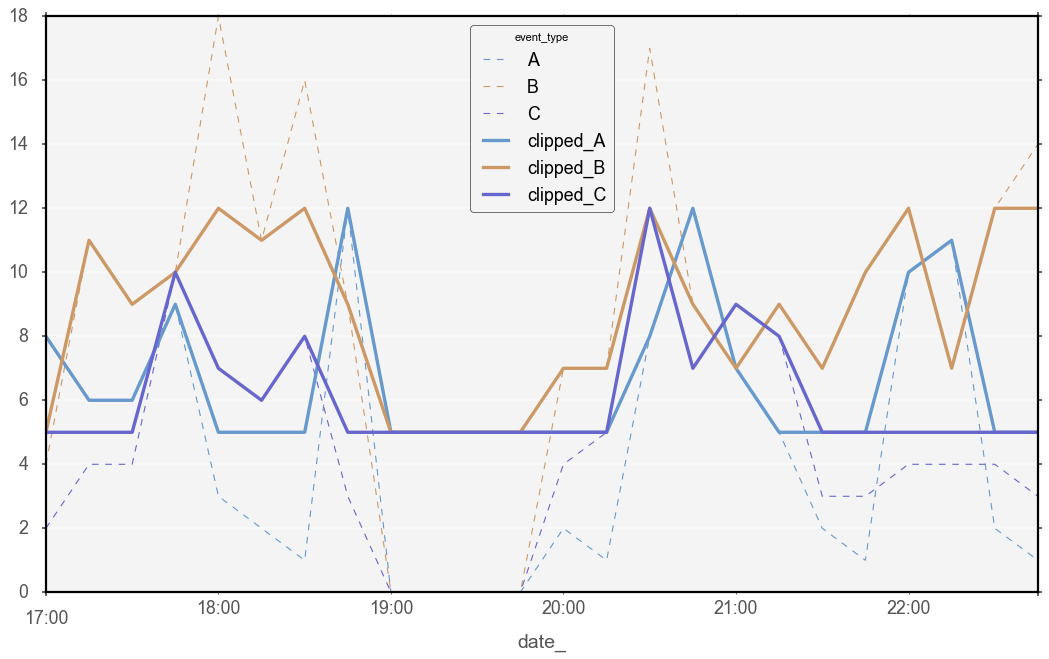

In [71]:
cl = pt.copy()
lb = 5
ub = 12
# Needed A loop of 3 lines
for col in ['A','B','C']:
    cl['clipped_{}'.format(col)] = cl[col]
    cl.loc[cl[col] < lb,'clipped_{}'.format(col)] = lb
    cl.loc[cl[col] > ub,'clipped_{}'.format(col)] = ub
my_utils.plot_clipped(cl) # my_utils can be found in the github repo

## A better way
`.clip(lb,ub)`

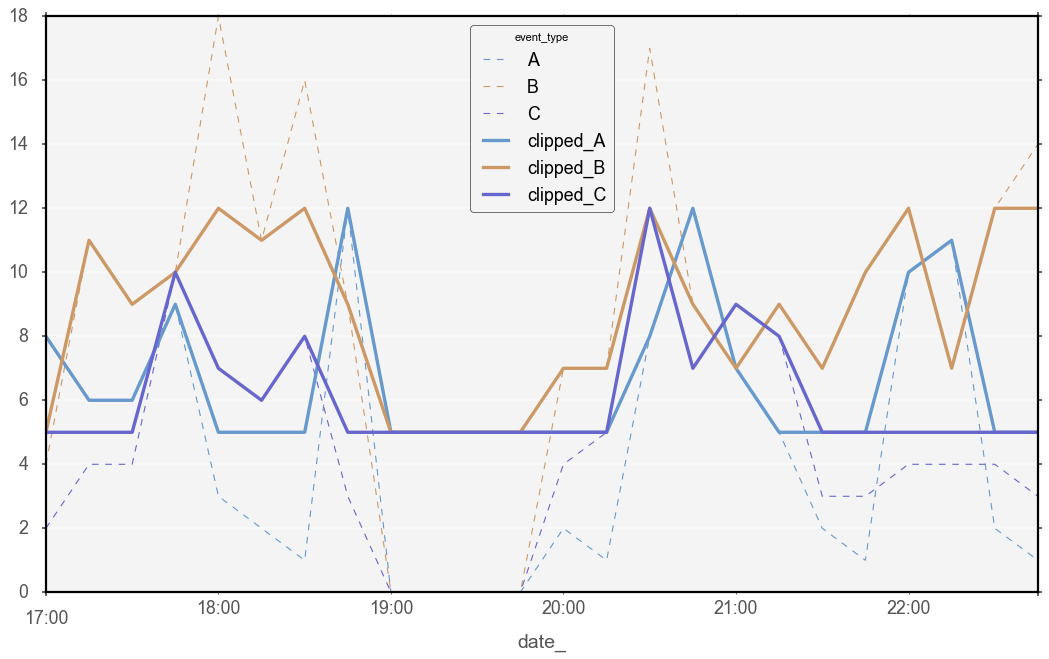

In [72]:

cl = pt.copy()
# Beutiful One Liner
cl[['clipped_A','clipped_B','clipped_C']] = cl.clip(5,12)
my_utils.plot_clipped(cl) # my_utils can be found in the github repo

# Reindex
Now I have 3 event types from 17:00 to 23:00. Let's imagine, I know that actually I have 5 event types. I also know that the period was from 16:00 to 00:00.

In [73]:
etypes = list('ABCDZ') # New columns

# Define a date range - Pandas will automatically make this into an index
idx = pd.date_range(start='2018-10-09 16:00:00',end='2018-10-09 23:59:00',freq='15T')
type(idx)

pandas.core.indexes.datetimes.DatetimeIndex

In [74]:
pt.reindex(idx, columns=etypes, fill_value=0).head()

event_type,A,B,C,D,Z
2018-10-09 16:00:00,0,0,0,0,0
2018-10-09 16:15:00,0,0,0,0,0
2018-10-09 16:30:00,0,0,0,0,0
2018-10-09 16:45:00,0,0,0,0,0
2018-10-09 17:00:00,8,4,2,0,0


In [76]:
### Let's put this in a function - This will help us later.
def get_all_types_and_timestamps(df, min_date='2018-10-09 16:00:00',
                                 max_date='2018-10-09 23:59:00', etypes=list('ABCDZ')):
    ret = df.copy()
    time_idx = pd.date_range(start=min_date,end=max_date,freq='15T')
    # Indices work like set. This is a good practive so we don't override our intended index
    idx = ret.index.union(time_idx)
    etypes = df.columns.union(set(etypes))
    ret = ret.reindex(idx, columns=etypes, fill_value=0)
    return ret

# Method Chaining

## Assign
Assign is for creating new columns on the dataframes. This is instead of
`df[new_col] = function(df[old_col])`. They are both one lines, but `.assign` doesn't break the flow.

In [77]:
pt.assign(mean_all = pt.mean(axis=1)).head()

event_type,A,B,C,mean_all
date_,,,,
2018-10-09 17:00:00,8,4,2,4.666667
2018-10-09 17:15:00,6,11,4,7.000000
2018-10-09 17:30:00,6,9,4,6.333333
2018-10-09 17:45:00,9,10,10,9.666667
2018-10-09 18:00:00,3,18,7,9.333333


## Pipe
Think R's %>% (Or rather, avoid thinking about R), `.pipe` is a method that accepts a function. `pipe`, by default, assumes the first argument of this function is a dataframe and passes the current dataframe down the pipeline. The function should return a dataframe also, if you want to continue with the pipe. Yet, it can also return any other value if you put it in the last step.  
This is incredibly valueable because it takes you one step further from "sql" where you do things "in reverse".  
$f(g(h(df)))$ = `df.pipe(h).pipe(g).pipe(f)`

In [78]:
def do_something(df, col='A', n = 200):
    ret = df.copy()
    # A dataframe is mutable, if you don't copy it first, this is prone to many errors.
    # I always copy when I enter a function, even if I'm sure it shouldn't change anything.
    ret[col] = ret[col] + n
    return ret

In [79]:
do_something(do_something(do_something(pt), 'B', 100), 'C',500).head()

event_type,A,B,C
date_,,,
2018-10-09 17:00:00,208,104,502
2018-10-09 17:15:00,206,111,504
2018-10-09 17:30:00,206,109,504
2018-10-09 17:45:00,209,110,510
2018-10-09 18:00:00,203,118,507


In [80]:
(pt
  .pipe(do_something)
  .pipe(do_something, col='B', n=100)
  .pipe(do_something, col='C', n=500)  
  .head(5))

event_type,A,B,C
date_,,,
2018-10-09 17:00:00,208,104,502
2018-10-09 17:15:00,206,111,504
2018-10-09 17:30:00,206,109,504
2018-10-09 17:45:00,209,110,510
2018-10-09 18:00:00,203,118,507


You can always do this with multiple lines of `df = do_something(df)` but I think this method is more elegant.

# Beautiful Code Tells a Story
Your code is not just about making the computer do things. It's about telling a story of what you wish to happen. Sometimes other people will want to read you code. Most time, it is you 3 monhts in the future who will want to read it. Some say good code documents itself. I'm not that extreme, yet storytelling with code may save you from many lines of unnecessary comments.
The next and final block tells the story in one block. It's elegant, it tells a story. If you build utility functions and `pipe` them while following meaningful naming, they help tell a story. if you `assign` columns with meaningful names, they tell a story. you `drop`, you `apply`, you `read`, you `groupby` and you `resample` - they all tell a story.

(Well... Maybe they could have gone with better naming for `resample`)

In [37]:
from import my_utils
df = (pd
      .read_csv    ('./data.csv', index_col=0, parse_dates=['date_'])
      .assign      (event_type=lambda df: df.event_type.map({1: 'A', 5: 'B', 7: 'C'}))
      .sort_values ('date_')
      .set_index   ('date_')
      .drop        (columns='val_updated')
      .groupby     ('event_type')
      .resample    ('15T')
      .apply       ('count')
      .rename      (columns={'event_type': 'amount'})
      .unstack     ('event_type')
      .pipe        (my_utils.remove_multi_index)
      .pipe        (get_all_types_and_timestamps) # Remember this from before?
      .assign      (mean_event=lambda df: df.mean(axis=1))
      .loc         [:, ['mean_event']]
      .pipe        (my_utils.make_sliding_time_windows, steps_back=6)
      .dropna      ()
      )

In [38]:
df.head()

,mean_event,mean_event_1,mean_event_2,mean_event_3,mean_event_4,mean_event_5,mean_event_6
2018-10-09 17:30:00,3.8,4.2,2.8,0.0,0.0,0.0,0.0
2018-10-09 17:45:00,5.8,3.8,4.2,2.8,0.0,0.0,0.0
2018-10-09 18:00:00,5.6,5.8,3.8,4.2,2.8,0.0,0.0
2018-10-09 18:15:00,3.8,5.6,5.8,3.8,4.2,2.8,0.0
2018-10-09 18:30:00,5.0,3.8,5.6,5.8,3.8,4.2,2.8


# You don't have to memorize this
Just put this in the back of your mind and remember that modern Pandas has so many superpowers. Just remember they exist, and google them when you actually need them.
Always, when I feel I'm insecure about Pandas, I go back to [Greg Reda](https://twitter.com/gjreda)'s [tweet](https://twitter.com/gjreda/status/1049694953687924737):

![greg](./slides/tweet.jpg)

# Resources 
* [Modern Pandas](https://tomaugspurger.github.io/modern-1-intro.html) by Tom Augspurger
* [Basic Time Series Manipulation with Pandas](https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea) by Laura Fedoruk
* [Pandas Docs](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.clip.html). You don't have to thoroughly go over everything, just randomly open a page in the docs and you're sure to learn a new thing. 